In [1]:
%load_ext autoreload
%autoreload 2

import torch
from diffusers.models import ControlNetModel
from diffusers.schedulers import DPMSolverMultistepScheduler

from text3d2video.utilities.camera_placement import front_facing_extrinsics
from text3d2video.utilities.mesh_processing import normalize_meshes
from text3d2video.rendering import render_depth_map
from text3d2video.utilities.video_util import pil_frames_to_clip
from pytorch3d.renderer import FoVOrthographicCameras
from pytorch3d.io import load_obj, load_objs_as_meshes

torch.set_grad_enabled(False)

mesh_path = "data/meshes/mixamo-human.obj"
device = "cuda"

# read mesh
verts, faces, aux = load_obj(mesh_path)
verts_uvs = aux.verts_uvs.to(device)
faces_uvs = faces.textures_idx.to(device)

mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)

s = 1.8
dist = 1

In [3]:
angles = torch.linspace(0, 360, 20)
xs = torch.linspace(-0.5, 0.5, 20)
R, T = front_facing_extrinsics(degrees=angles, zs=dist)

frame_cams = FoVOrthographicCameras(R=R, T=T, device="cuda", scale_xyz=[(s, s, s)])
frame_meshes = mesh.extend(len(frame_cams))

depths = render_depth_map(frame_meshes, frame_cams)

pil_frames_to_clip(depths).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [4]:
R, T = front_facing_extrinsics(degrees=0, zs=dist)

aggr_cams = FoVOrthographicCameras(R=R, T=T, device="cuda", scale_xyz=[(s, s, s)])
aggr_meshes = mesh.extend(len(aggr_cams))

depths = render_depth_map(aggr_meshes, aggr_cams)
pil_frames_to_clip(depths).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [5]:
from text3d2video.generative_rendering.generative_rendering_pipeline import GenerativeRenderingPipeline

device = torch.device("cuda")
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

controlnet = ControlNetModel.from_pretrained(controlnet_repo, torch_dtype=dtype).to(
    device
)

pipe: GenerativeRenderingPipeline = GenerativeRenderingPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
from text3d2video.artifacts.gr_data import GrSaveConfig
from text3d2video.generative_rendering.configs import GenerativeRenderingConfig
from text3d2video.noise_initialization import UVNoiseInitializer

module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    # "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

gr_config = GenerativeRenderingConfig(
    seed=1,
    resolution=512,
    do_pre_attn_injection=True,
    do_post_attn_injection=True,
    feature_blend_alpha=1.0,
    attend_to_self_kv=False,
    mean_features_weight=1.0,
    chunk_size=5,
    num_keyframes=1,
    num_inference_steps=10,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

gr_save_cfg = GrSaveConfig(
    enabled=False,
    n_frames=5,
    n_timesteps=5,
    save_latents=False,
    save_q=True,
    save_k=True,
    save_v=True,
    out_artifact="rumba",
    module_paths=module_paths,
    save_kf_post_attn=False,
    save_aggregated_features=False,
    save_feature_images=False
)

prompt = "Deadpool, simple blank background"

noise_initializer = UVNoiseInitializer()

video_frames = pipe(
    prompt,
    frame_meshes,
    frame_cams,
    verts_uvs,
    faces_uvs,
    generative_rendering_config=gr_config,
    noise_initializer=noise_initializer,
    gr_save_config=gr_save_cfg,
)

art = pipe.gr_data_artifact

# display_ims(video_frames)

100%|██████████| 10/10 [00:28<00:00,  2.83s/it]


In [7]:
vid_frames = video_frames[0:len(frame_cams)]
aggr_frames = video_frames[len(frame_cams):]

pil_frames_to_clip(vid_frames, duration=1.5).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


: 

In [7]:
import os
from text3d2video.artifacts.gr_data import GrDataArtifact
from text3d2video.sd_feature_extraction import read_layer_paths
print(os.system(f'du -h {art.folder}'))

art: GrDataArtifact = art

frame_indices = art.diffusion_data.save_frame_indices
time_steps = art.diffusion_data.save_step_times
modules = art.diffusion_data.save_module_paths

enc_layers, mid_layers, dec_layers = read_layer_paths(modules)

8,0K	/tmp/local_artifacts/gr_data/rumba
0


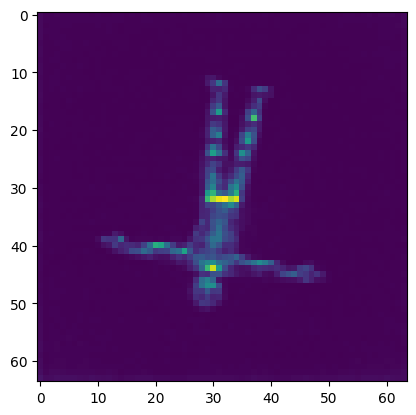

In [94]:
from matplotlib import pyplot as plt
from torch import Tensor
from text3d2video.attention_visualization import (
    compute_attn_weights,
    coord_to_pixel,
    pixel_coord_flattened,
    split_heads,
)


module = modules[-1]
frame = frame_indices[2]
time = time_steps[2]

# get features
key = art.attn_writer.read_key(time, frame, module)
qry = art.attn_writer.read_qry(time, frame, module)
val = art.attn_writer.read_val(time, frame, module)

# for a particular head
key_mh = split_heads(key.unsqueeze(0))
qry_mh = split_heads(qry.unsqueeze(0))
val_mh = split_heads(val.unsqueeze(0))
head_idx = 2
key_head = key_mh[0, :, head_idx, :]
qry_head = qry_mh[0, :, head_idx, :]
val_head = val_mh[0, :, head_idx, :]

# compute attention weights
attn_weights = compute_attn_weights(qry_head.unsqueeze(0), key_head.unsqueeze(0), temperature=3)[0]

qry_coord = Tensor([0.5, 0.5])

layer_res = 64
qry_grid_size = (layer_res, layer_res)

qry_pix = coord_to_pixel(qry_coord, qry_grid_size)
qry_pix_1d = pixel_coord_flattened(qry_pix, qry_grid_size)


row = attn_weights[qry_pix_1d]

row_square = row.reshape(layer_res, layer_res)

plt.imshow(row_square.cpu().numpy())

In [ ]:

qry_coord = Tensor([0.5, 0.5])

layer_res = 64
qry_grid_size = (layer_res, layer_res)

qry_pix = coord_to_pixel(qry_coord, qry_grid_size)
qry_pix_1d = pixel_coord_flattened(qry_pix, qry_grid_size)

head_idx = 2
key_mh = split_heads(key.unsqueeze(0))
qry_mh = split_heads(qry.unsqueeze(0))
val_mh = split_heads(val.unsqueeze(0))

key_head = key_mh[0, :, head_idx, :]
qry_head = qry_mh[0, :, head_idx, :]
val_head = val_mh[0, :, head_idx, :]

attn_weights = compute_attn_weights(qry_head.unsqueeze(0), key_head.unsqueeze(0), temperature=0.1)[0]

row = attn_weights[qry_pix_1d]

row_square = row.reshape(layer_res, layer_res)

plt.imshow(row_square.cpu().numpy())